<a href="https://colab.research.google.com/github/estebanegm/PINN_example/blob/main/PINN_example_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Definir la red neuronal
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1)
])

In [3]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)

In [5]:
# def ode_system(t, net, omega):
#     t = t.reshape(-1, 1)
#     t = tf.constant(t, dtype=tf.float32)

#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch(t)

#         x = net(t)  # La red neuronal representa la posición x en función de t
#         x_first_deriv = tape.gradient(x, t)

#     x_second_deriv = tape.gradient(x_first_deriv, t)
#     del tape

#     ode_loss = x_second_deriv + (omega ** 2) * x
#     IC_loss = x - 1.0  # Condición inicial de posición

#     square_loss = tf.square(ode_loss) + tf.square(IC_loss)
#     total_loss = tf.reduce_mean(square_loss)

#     return total_loss

def ode_system(t, net, omega):
    t = t.reshape(-1, 1)
    t = tf.constant(t, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)

        x = net(t)  # La red neuronal representa la posición x en función de t
        x_first_deriv = tape.gradient(x, t)

    x_second_deriv = tape.gradient(x_first_deriv, t)
    del tape  # Liberar el recurso de la cinta persistente

    # Condiciones iniciales
    position_loss = x - 1
    velocity_loss = x_first_deriv - 0

    ode_loss = x_second_deriv + (omega ** 2) * x

    square_loss = tf.square(ode_loss) + tf.square(position_loss) + tf.square(velocity_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [6]:
# Parámetros del oscilador armónico simple
omega = 2.0

# Datos de entrenamiento
train_t = np.linspace(0, 10, 100).reshape(-1, 1)

train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN, omega)
        train_loss_record.append(train_loss)

    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

2.9422967
0.94013596
0.93889534
0.93756586
0.93687713
0.93657976


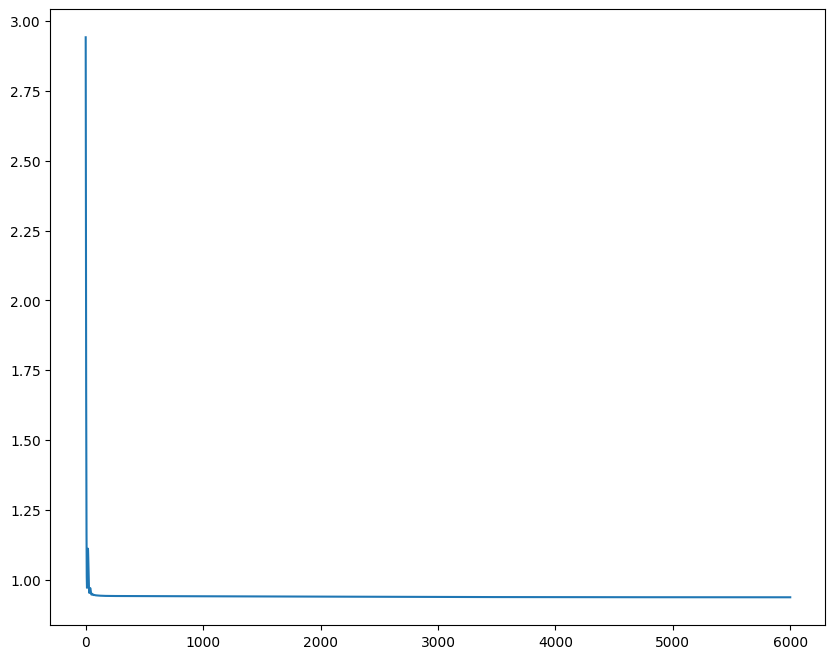

In [7]:
# Gráfica de la pérdida durante el entrenamiento
plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()


4/4 [==============================] - 0s 6ms/step


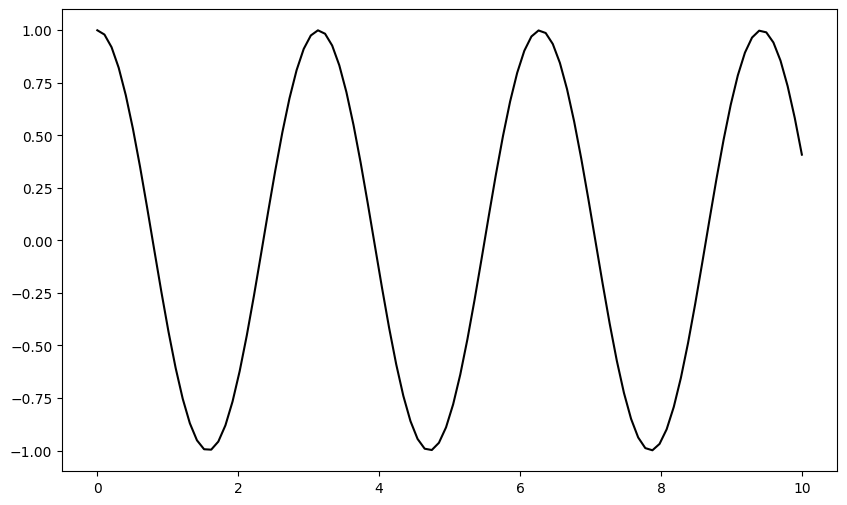

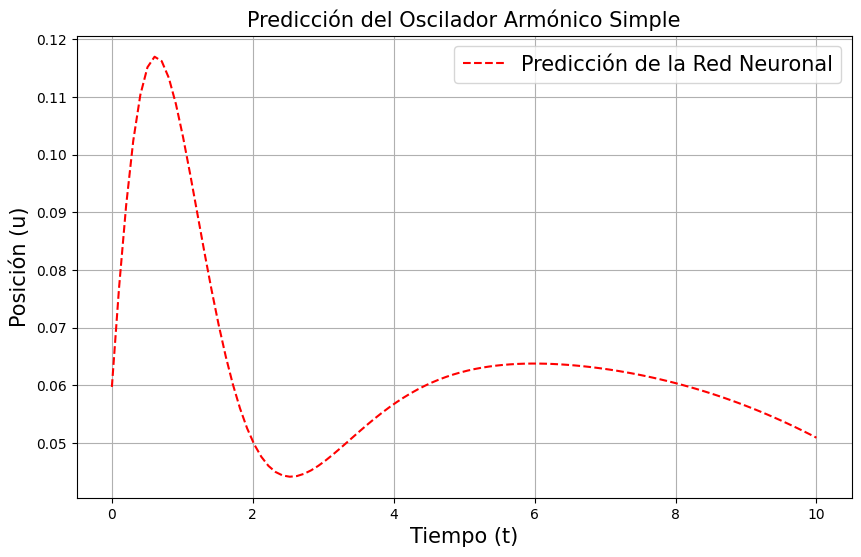

In [8]:
# Valores de prueba
test_t = np.linspace(0, 10, 100)

omega = 2.0  # Frecuencia angular del oscilador
A = 1.0  # Amplitud del oscilador
phi = 0.0  # Fase inicial del oscilador

# Solución real del oscilador armónico simple
true_u = A * np.cos(omega * test_t + phi)

#Predicción
pred_u = NN.predict(test_t).ravel()

# Gráfica de la solución real y la predicción
plt.figure(figsize=(10, 6))
plt.plot(test_t, true_u, '-k', label='Solución Real')
# Gráfica de la predicción
plt.figure(figsize=(10, 6))
plt.plot(test_t, pred_u, '--r', label='Predicción de la Red Neuronal')
plt.legend(fontsize=15, loc='upper right')
plt.xlabel('Tiempo (t)', fontsize=15)
plt.ylabel('Posición (u)', fontsize=15)
plt.title('Predicción del Oscilador Armónico Simple', fontsize=15)
plt.grid(True)
plt.show()